## K-Nearest Neighbors Model
K-Nearest Neighbors is a non-parametric model, which means the underlying data does not follow any particular probability distribution.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DSC-680 Capstone/output/sample_data_modeling.csv')

In [4]:
df['click_time'] = pd.to_datetime(df['click_time'])
df['click_date'] = pd.to_datetime(df['click_date'])

In [5]:
df['is_attributed'].value_counts()

0    46184
1     9065
Name: is_attributed, dtype: int64

### Create Training and Test sets

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
X = df[['median_time_diff_app', 'median_time_diff_channel',
        'hour_0_to_8', 'hour_8_to_16',
        'hour_16_to_24', 'app_encoded',
        'channel_encoded', 'os_encoded', 'device_encoded', 'ctr']]

In [8]:
feature_names = X.columns
feature_names

Index(['median_time_diff_app', 'median_time_diff_channel', 'hour_0_to_8',
       'hour_8_to_16', 'hour_16_to_24', 'app_encoded', 'channel_encoded',
       'os_encoded', 'device_encoded', 'ctr'],
      dtype='object')

In [9]:
y = df['is_attributed']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [11]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (41436, 10)
X_test shape: (13813, 10)


### Feature Selection
Find best features using forward feature selection method.  The best features are chosen in "greedy" fashion sequentially until the model score no longer improves beyond a certain threshold.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV

In [13]:
# create Pipeline
feature_pipe = Pipeline(steps=[
    ('standard_scaler', StandardScaler()),
    ('select', SequentialFeatureSelector(estimator=KNeighborsClassifier(), n_features_to_select=5)),
    ])

feature_pipe.fit(X_train, y_train)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('select',
                 SequentialFeatureSelector(estimator=KNeighborsClassifier(),
                                           n_features_to_select=5))])

In [14]:
feature_names_new = feature_names[feature_pipe[-1].get_support()]
feature_names_new

Index(['hour_8_to_16', 'channel_encoded', 'os_encoded', 'device_encoded',
       'ctr'],
      dtype='object')

In [15]:
X_new = X[feature_names_new]

In [16]:
print(f'X_new.shape: {X_new.shape}')

X_new.shape: (55249, 5)


In [17]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, random_state=1)

### GridSearchCV

In [18]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [19]:
pipe = Pipeline(steps=[
    ('standard_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
    ])

In [20]:
param_grid = {'knn__n_neighbors': [2,3,4]}

In [21]:
s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=s_kfold)

In [22]:
grid.fit(X_train_new, y_train_new)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [2, 3, 4]})

In [23]:
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test_new, y_test_new)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 1.00
Test set score: 1.00
Best parameters: {'knn__n_neighbors': 4}


In [24]:
grid.best_params_['knn__n_neighbors']

4

In [25]:
n_neighbors = grid.best_params_['knn__n_neighbors']
n_neighbors

4

### Cross Validation

In [26]:
cv_pipe = Pipeline(steps=[
    ('standard_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=n_neighbors))
    ])

In [27]:
s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(cv_pipe, X_train_new, y_train_new, cv=s_kfold)
scores

array([0.99638031, 0.99734524, 0.9962592 , 0.99722457, 0.99746591])

In [28]:
scores.mean()

0.996935045726828

### Evaluate on Test data set
Retrain K-Nearest Neighbors model with all of the training data with the selected set of features.  Setup pipeline to apply standard scaler to training data and train K-NN model.

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [30]:
def display_confusion_matrix(cm, title, pipe):
  '''
  Plot confusion matrix

  params:
    cm: confusion matrix
  '''
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

  fig, ax = plt.subplots(figsize=(5,4))
  ax.set_title(title)
  disp.plot(ax=ax, cmap='Blues')
  plt.show()

In [31]:
def print_classification_report(cm):
  '''
  Print classification report

  params:
    cm: confusion matrix
  '''
  tn, fp, fn, tp = cm.ravel()
  accuracy = (tp + tn) / (tp + fp + tn + fn)
  print(f"Accuracy: {accuracy}")

  print(f'True negatives: {tn}')
  print(f'False positives: {fp}')
  print(f'False negatives: {fn}')
  print(f'True positives: {tp}')

  print(classification_report(y_true, y_pred))

In [32]:
# create pipeline
test_pipe = Pipeline([('scaler', StandardScaler()),
              ('knn', KNeighborsClassifier(n_neighbors=n_neighbors))])

test_pipe.fit(X_train_new, y_train_new)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=4))])

In [33]:
test_pipe.score(X_test_new, y_test_new)

0.9963802215304424

In [34]:
y_true = y_test
y_pred = test_pipe.predict(X_test_new)

In [35]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[11532,    16],
       [   34,  2231]])

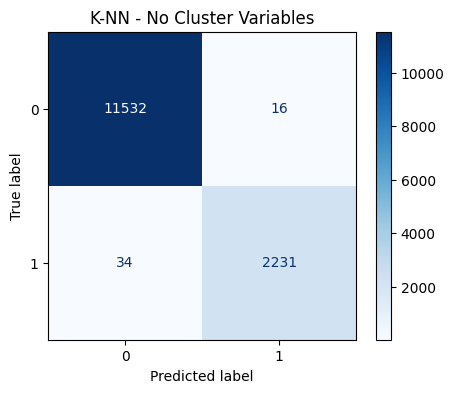

In [36]:
display_confusion_matrix(cm, 'K-NN - No Cluster Variables', test_pipe)

In [37]:
print_classification_report(cm)

Accuracy: 0.9963802215304424
True negatives: 11532
False positives: 16
False negatives: 34
True positives: 2231
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11548
           1       0.99      0.98      0.99      2265

    accuracy                           1.00     13813
   macro avg       0.99      0.99      0.99     13813
weighted avg       1.00      1.00      1.00     13813



### Evaluate with Cluster categorical variables

In [38]:
X = df[['median_time_diff_app', 'median_time_diff_channel',
        'hour_0_to_8', 'hour_8_to_16',
        'hour_16_to_24', 'app_encoded',
        'channel_encoded', 'os_encoded', 'device_encoded', 'ctr',
        'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']]

In [39]:
new_feature_cols = feature_names_new.tolist()
new_feature_cols.extend(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3'])
new_feature_cols

['hour_8_to_16',
 'channel_encoded',
 'os_encoded',
 'device_encoded',
 'ctr',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3']

#### Retrain on new cluster columns

In [40]:
X.columns

Index(['median_time_diff_app', 'median_time_diff_channel', 'hour_0_to_8',
       'hour_8_to_16', 'hour_16_to_24', 'app_encoded', 'channel_encoded',
       'os_encoded', 'device_encoded', 'ctr', 'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3'],
      dtype='object')

In [41]:
X_new = X[new_feature_cols]
X_new.columns

Index(['hour_8_to_16', 'channel_encoded', 'os_encoded', 'device_encoded',
       'ctr', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3'],
      dtype='object')

In [42]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, random_state=1)

In [43]:
X_train_new.shape

(41436, 9)

In [44]:
y_train_new.shape

(41436,)

In [45]:
# create pipeline
test_pipe = Pipeline([('scaler', StandardScaler()),
              ('knn', KNeighborsClassifier(n_neighbors=n_neighbors))])

test_pipe.fit(X_train_new, y_train_new)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=4))])

In [46]:
test_pipe.score(X_test_new, y_test_new)

0.9965250126692247

In [47]:
y_true = y_test
y_pred = test_pipe.predict(X_test_new)

In [48]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[11533,    15],
       [   33,  2232]])

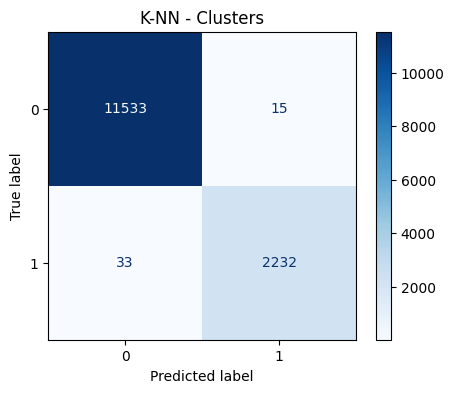

In [51]:
display_confusion_matrix(cm, 'K-NN - Clusters', test_pipe)

In [50]:
print_classification_report(cm)

Accuracy: 0.9965250126692247
True negatives: 11533
False positives: 15
False negatives: 33
True positives: 2232
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11548
           1       0.99      0.99      0.99      2265

    accuracy                           1.00     13813
   macro avg       1.00      0.99      0.99     13813
weighted avg       1.00      1.00      1.00     13813

